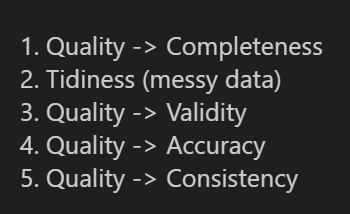

In [1]:
import pandas as pd
import numpy as np

In [2]:
patients = pd.read_csv(r"D:\CampMain\DSMP 1.0\2) Python\3) Data analysis Process\02) week 12\01) Data Assessing and Cleaning\06 clinical_trails\data\patients.csv")
treatments = pd.read_csv(r"D:\CampMain\DSMP 1.0\2) Python\3) Data analysis Process\02) week 12\01) Data Assessing and Cleaning\06 clinical_trails\data\treatments.csv")
adverse_reactions = pd.read_csv(r"D:\CampMain\DSMP 1.0\2) Python\3) Data analysis Process\02) week 12\01) Data Assessing and Cleaning\06 clinical_trails\data\adverse_reactions.csv")
treatments_cut = pd.read_csv(r"D:\CampMain\DSMP 1.0\2) Python\3) Data analysis Process\02) week 12\01) Data Assessing and Cleaning\06 clinical_trails\data\treatments_cut.csv")

In [3]:
patients_df = patients.copy()
treatments_df = treatments.copy()
treatments_cut_df = treatments_cut.copy()
adverse_reactions_df = adverse_reactions.copy()

# # completeness

### Define

- replace all missing values of patients df with no data
- sub hba1c_start from hba1c_end to get all the change values
- in patients table we will use regex to separate email and phone

In [4]:
patients_df[['address', 'city', 'state', 'zip_code', 'country', 'contact']] = patients_df[['address', 'city', 'state', 'zip_code', 'country', 'contact']].fillna("No Data")

In [5]:
# code
treatments_df['hba1c_change'] = treatments_df['hba1c_start'] - treatments_df['hba1c_end']
treatments_cut_df['hba1c_change'] = treatments_cut_df['hba1c_start'] - treatments_cut_df['hba1c_end']

In [6]:
treatments_df['hba1c_change'].isnull().sum()

0

# Tidiness

##Define

- separate email and phone number
- conact treatments_df and treatments_cut_df
- make a column type by using auralin and novadra
- make two separate columns for start dose and end dose from dosage_range
- perform left join on treatments_df and adverse_reactions_df

In [7]:
# Extract phone numbers
patients_df['phone_number'] = patients_df['contact'].str.extract((r'(\+\d{1,2}\s?\(\d{3}\)\s?\d{3}-\d{4}|\d{3}-\d{3}-\d{4}|\d\s\d{3}\s\d{3}\s\d{4}|\d{10})'))

# Extract email addresses
patients_df['email'] = patients_df['contact'].str.extract(r'([a-zA-Z._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})')

# Drop the original contact column
patients_df.drop(columns=['contact'], inplace=True)

# Display the updated DataFrame
patients_df.head()

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,California,92390.0,United States,7/10/1976,121.7,66,19.6,951-719-9170,ZoeWellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,Illinois,61812.0,United States,4/3/1967,118.8,66,19.2,+1 (217) 569-3204,PamelaSHill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,Nebraska,68467.0,United States,2/19/1980,177.8,71,24.8,402-363-6804,JaeMDebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,7095.0,United States,7/26/1951,220.9,70,31.7,+1 (732) 636-8246,PhanBaLiem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303.0,United States,2/18/1928,192.3,27,26.1,334-515-7487,TimNeudorf@cuvox.de


In [52]:
treatments_df.shape, treatments_cut_df.shape

((280, 7), (70, 7))

In [8]:
treatments_df = pd.concat([treatments_df,treatments_cut_df], ignore_index=True, axis=0)

treatments_df.shape

(350, 7)

In [9]:
treatments_df = treatments_df.melt(id_vars=['given_name', 'surname' ,'hba1c_start', 'hba1c_end','hba1c_change'],var_name='type',value_name='dosage_range')

treatments_df = treatments_df[treatments_df['dosage_range'] != '-'].reset_index(drop=True)

In [10]:
treatments_df['dosage_start'] = treatments_df['dosage_range'].apply(lambda x: x.split('-')[0].strip().rstrip('u'))
treatments_df['dosage_end'] = treatments_df['dosage_range'].apply(lambda x: x.split('-')[1].strip().rstrip('u'))

In [11]:
# drop the original column
treatments_df.drop(columns='dosage_range',inplace=True)

In [12]:
# change dosage_start dtype to int
treatments_df['dosage_start'] = treatments_df['dosage_start'].astype(int)
treatments_df['dosage_end'] = treatments_df['dosage_end'].astype(int)

In [13]:
treatments_df = treatments_df.merge(adverse_reactions_df, how ='left', on=['given_name','surname'])

# Validity

## Define

- convert zip code to string
- apply zfill() only to rows that contain numeric ZIP codes
- add inplace of No Data '00000' or '99999' to zip code

- convert assigned_sex to category dtype
- convert birthdate to datetime dtype

- remove duplicate entries by the given_name and surname from patients_df
- patient_id = 9 has misspelled name 'Dsvid' instead of David
- remove duplicate entries by the given_name and surname from treatments_df

In [16]:
patients_df.loc[patients_df['zip_code'].isin(['No Data', '99999']), 'zip_code'] = '00000'

In [17]:
# Convert zip_code to string type
patients_df['zip_code'] = patients_df['zip_code'].astype(str).apply(lambda x: x[:-2] if '.' in x else x)

# Apply zfill() only to rows that contain numeric ZIP codes
patients_df['zip_code'] = patients_df['zip_code'].apply(lambda x: x.zfill(5) if x.isdigit() else x)

# add inplace of No Data '00000' or '99999' to zip code
patients_df.loc[patients_df['zip_code'].isin(['No Data', '99999']), 'zip_code'] = '00000'

The `object dtype` is a catch-all for columns that can contain any Python object but are not of a specific numeric or datetime type. Columns with the object dtype can store strings of varying lengths and may contain mixed types of data.

Categorical data is often used to represent variables that have a finite number of distinct categories or levels. By converting a column to the category dtype, you can potentially save memory and improve performance, especially if the column has a relatively small number of unique values and is frequently used for analysis or visualization.

In [18]:
# Convert assigned_sex to category dtype
patients_df['assigned_sex'] = patients_df['assigned_sex'].astype('category')

In [19]:
# Convert birthdate to datetime dtype
patients_df['birthdate'] = pd.to_datetime(patients_df['birthdate'])

In [20]:
patients_df.loc[patients_df['patient_id'] == 9, 'given_name']

8    Dsvid
Name: given_name, dtype: object

# consistency

## Define
- state col sometimes contain full name and some times abbrivietation in patients_df
- given_name and surname col is is all lower case in treatments_df, make it Title case

In [21]:
import pprint
state_list = patients_df['state'].unique().tolist()

Dict = {}
for state in state_list:
    if state[0] in Dict.keys():
        Dict[state[0]].append(state)
    else:
        Dict[state[0]] = [state]

pprint.pprint(Dict)

{'A': ['AL', 'AZ', 'AK', 'AR'],
 'C': ['California', 'CA', 'CO', 'CT'],
 'D': ['DE', 'DC'],
 'F': ['Florida', 'FL'],
 'G': ['GA'],
 'I': ['Illinois', 'IL', 'IA', 'IN', 'ID'],
 'K': ['KY', 'KS'],
 'L': ['LA'],
 'M': ['MO', 'MI', 'MT', 'MA', 'ME', 'MN', 'MD', 'MS'],
 'N': ['Nebraska',
       'NJ',
       'NV',
       'New York',
       'NY',
       'NM',
       'NC',
       'NE',
       'ND',
       'NH',
       'No Data'],
 'O': ['OK', 'OH', 'OR'],
 'P': ['PA'],
 'R': ['RI'],
 'S': ['SD', 'SC'],
 'T': ['TN', 'TX'],
 'V': ['VA', 'VT'],
 'W': ['WI', 'WY', 'WA', 'WV']}


In [22]:
Replace = {'California':'CA', 'New York':'NY', 'Illinois':'IL', 'Florida':'FL', 'Nebraska':'NE'}

patients_df['state'] = patients_df['state'].replace(Replace)

In [23]:
# Title case
treatments_df['given_name'] = treatments_df['given_name'].str.title()
treatments_df['surname'] = treatments_df['surname'].str.title()

# Accuracy

### Define
- Dsvid is misspelled in patients_df
- remove duplicate entries by the given_name and surname
- one patient has weight = 48 pounds
- one patient has height = 27 inches and 79 inches

In [24]:
# patient_id = 9 has misspelled name 'Dsvid' instead of David
patients_df.loc[patients_df['patient_id'] == 9, 'given_name'] = 'David'

In [25]:
# remove duplicate entries by the given_name and surname
patients_df.drop_duplicates(subset=['given_name', 'surname'], keep='first', inplace=True)
treatments_df.drop_duplicates(subset=['given_name', 'surname'], keep='first', inplace=True)

In [26]:
def find_outliers(column):
    # Calculate the first quartile (Q1)
    Q1 = column.quantile(0.25)
    # Calculate the third quartile (Q3)
    Q3 = column.quantile(0.75)
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outliers
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Example usage:
height_outliers = find_outliers(patients_df['height'])
weight_outliers = find_outliers(patients_df['weight'])
print("Outlier values:")
print(height_outliers)
print()
print(weight_outliers)

Outlier values:
4      27
418    79
Name: height, dtype: int64

210    48.8
Name: weight, dtype: float64


In [72]:
patients_df[patients_df['height'].isin(height_outliers)]

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303,United States,1928-02-18,192.3,27,26.1,334-515-7487,TimNeudorf@cuvox.de
418,419,male,Mahmud,Kadyrov,3390 Hidden Meadow Drive,Stanton,ND,58571,United States,1980-06-18,215.2,79,24.2,1 701 745 2700,MahmudKadyrov@gustr.com


In [27]:
import math
def find_height(BMI , weight_lbs):
    # Convert weight from pounds to kilograms
    weight_kg = weight_lbs * 0.453592  # 1 pound = 0.453592 kilograms

    # Calculate height in meters
    height_m = math.sqrt(weight_kg / BMI)

    # Convert height from meters to inches
    height_in = height_m / 0.0254  # 1 inch = 0.0254 meters

    print("Height in inches:", height_in)


find_height(26.1, 192.3)
# This is incorrect

Height in inches: 71.97279442384996


In [28]:
# replace 71 

patients_df.loc[patients_df['patient_id'] == 5, 'height'] = 71

In [29]:
find_height(24.2, 215.2)
# This is correct

Height in inches: 79.07012530494485


bmi = kg/ m^2

In [30]:
patients_df[patients_df['weight'].isin(weight_outliers)]

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
210,211,female,Camilla,Zaitseva,4689 Briarhill Lane,Wooster,OH,44691,United States,1938-11-26,48.8,63,19.1,330-202-2145,CamillaZaitseva@superrito.com


In [31]:
def find_weight(BMI , height_in):

    # Convert height from inches to meters
    height_m = height_in * 0.0254  # 1 inch = 0.0254 meters

    # Calculate weight in kilograms
    weight_kg = BMI * (height_m ** 2)

    # Convert weight from kilograms to pounds
    weight_lbs = weight_kg / 0.453592  # 1 pound = 0.453592 kilograms

    print("Weight in pounds:", weight_lbs)

find_weight(19.1 , 63)

Weight in pounds: 107.82426666255137


In [32]:
# replace 107.82

patients_df.loc[patients_df['patient_id'] == 211, 'weight'] = 107.82

In [33]:
def find_outliers(column):
    # Calculate the first quartile (Q1)
    Q1 = column.quantile(0.25)
    # Calculate the third quartile (Q3)
    Q3 = column.quantile(0.75)
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outliers
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Example usage:
height_outliers = find_outliers(patients_df['height'])
weight_outliers = find_outliers(patients_df['weight'])
print("Outlier values:")
print(height_outliers)
print()
print(weight_outliers)

Outlier values:
Series([], Name: height, dtype: int64)

Series([], Name: weight, dtype: float64)


In [34]:
# check 'No Data' match in any column
patients_df.isin(['No Data', '99999', '00000']).any(axis=0)

patient_id      False
assigned_sex    False
given_name      False
surname         False
address          True
city             True
state            True
zip_code         True
country          True
birthdate       False
weight          False
height          False
bmi             False
phone_number    False
email           False
dtype: bool

In [35]:
patients_df.reset_index(drop=True, inplace=True)

In [36]:
Id = [30, 283, 503]

Index = patients_df[patients_df['patient_id'].isin(Id)].index
patients_df.drop(Index, inplace=True)

In [37]:
patients_df.reset_index(drop=True, inplace=True)

In [38]:
# rename the column name weight and height
patients_df.rename(columns={'weight':'weight_lbs', 'height':'height_in'}, inplace=True)

In [39]:
data = patients_df.copy()

In [47]:
data = data.merge(treatments_df, how ='left', on=['given_name','surname'])

In [49]:
data.reset_index(drop=True, inplace=True)

In [51]:
data.drop(data[data['type'].isnull()].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [53]:
data.shape

(344, 22)

In [59]:
data['adverse_reaction'].fillna('Other', inplace=True)

In [60]:
import pickle

with open('clinical_trials.pickle', 'wb') as f:
    pickle.dump(data, f)